<a href="https://colab.research.google.com/github/RicardoR002/NLP-CAI2300C/blob/main/Improved_Ecom_Sentiment_Analysis_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Loading the Dataset

This project examines customer reviews from a Women's Clothing E-Commerce dataset. It features nine supportive dimensions for comprehensive text analysis. Goal is to predict positive or negative sentiment based on the reviews.

Ricardo Ruano CAI2300C

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('https://github.com/RicardoR002/Data/raw/refs/heads/main/Womens%20Clothing%20E-Commerce%20Reviews.csv')
df.sample(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
863,863,886,29,Comfortable,Love this shirt! i bought the light blue color...,5,1,0,General Petite,Tops,Knits
4574,4574,820,58,Versatile,I bought this shirt in a size 10. i am a 32 4d...,5,1,0,General,Tops,Blouses
681,681,1087,62,Simple but different.,I bought this dress in the cream color. it was...,4,1,1,General,Dresses,Dresses
8299,8299,1078,54,NaN,Frumpy - looked like a nightgown on me; maybe ...,2,0,0,General Petite,Dresses,Dresses
23344,23344,1110,25,Beautiful dress,This dress is great! it's easy to dress up or ...,5,1,0,General Petite,Dresses,Dresses


In [2]:
# Remove unnecessary columns
del df['Unnamed: 0']

In [3]:
# Print initial statistics
print('Total number of reviews:', df.shape[0])
print('Number of Duplicates:', len(df[df.duplicated()]))
print('Number of Missing Values:', df.isnull().sum().sum())
print('\nMissing Values per column:')
print(df.isnull().sum().sort_values(ascending=False))

Total number of reviews: 23486
Number of Duplicates: 21
Number of Missing Values: 4697

Missing Values per column:
Title                      3810
Review Text                 845
Division Name                14
Department Name              14
Class Name                   14
Clothing ID                   0
Age                           0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
dtype: int64


## 2. Data Cleaning and Preprocessing

In [4]:
# Remove rows with nulls except Title
df = df.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'])

# Enhanced text cleaning function
def clean_text(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove non-alphabet characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower().strip()
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove very short words
        text = ' '.join([word for word in text.split() if len(word) > 2])
        return text
    return ''

# Feature Engineering
df['review_length'] = df['Review Text'].str.len()
df['word_count'] = df['Review Text'].str.split().str.len()

# Combine Review Text with Title
df['combined_text'] = df.apply(
    lambda x: x['Title'] + ' ' + x['Review Text'] if pd.notnull(x['Title'])
    else x['Review Text'], axis=1
)

# Clean the combined text
df['combined_text'] = df['combined_text'].apply(clean_text)

# Tokenization and padding
MAX_WORDS = 10000
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH)


<ipython-input-4-0703f8a2b54b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_length'] = df['Review Text'].str.len()


## 3. Split data into features and Target label (Recommended IND)

In [5]:
# Splitting the data into features (X) and labels (y)
X = padded_sequences
y = df['Recommended IND'].values

In [6]:
# Handle class imbalance
class_weights = dict(zip(
    np.unique(y),
    1 / np.bincount(y) * len(y) / 2
))

## 4. Splitting the Data into Training and Testing Sets

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 5. Building the Neural Network with TensorFlow

In [8]:
# Create the improved model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 32, input_length=MAX_LENGTH),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_reducer]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 175s 366ms/step - accuracy: 0.6851 - auc: 0.7575 - loss: 0.5519 - val_accuracy: 0.8685 - val_auc: 0.9356 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 2/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 196s 353ms/step - accuracy: 0.8869 - auc: 0.9537 - loss: 0.2634 - val_accuracy: 0.8492 - val_auc: 0.9432 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 3/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 204s 358ms/step - accuracy: 0.9109 - auc: 0.9690 - loss: 0.2127 - val_accuracy: 0.8851 - val_auc: 0.9408 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 4/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 163s 361ms/step - accuracy: 0.9407 - auc: 0.9815 - loss: 0.1466 - val_accuracy: 0.8785 - val_auc: 0.9395 - val_loss: 0.3516 - learning_rate: 5.0000e-04


## 6. Visualizing Model Performance

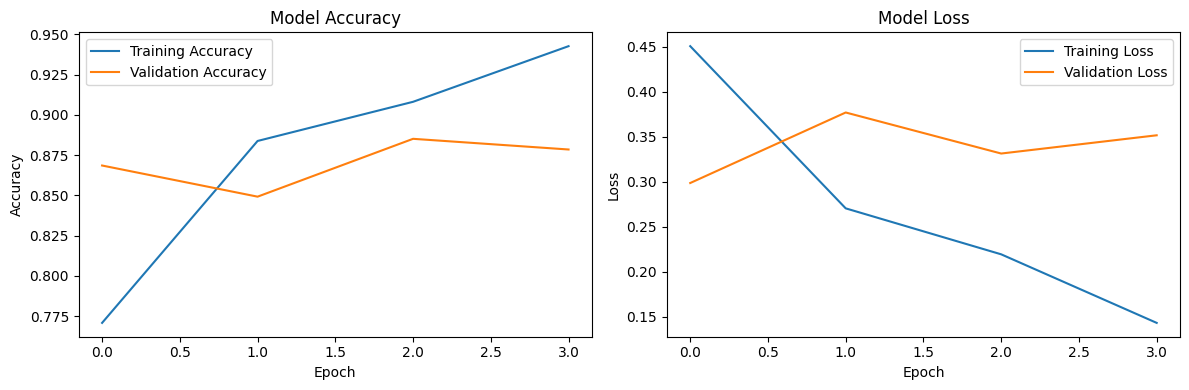

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluating the Model

142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.8774 - auc: 0.9365 - loss: 0.2911

Test Accuracy: 0.8694
Test AUC: 0.9327
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.86      0.70       820
           1       0.96      0.87      0.92      3706

    accuracy                           0.87      4526
   macro avg       0.78      0.86      0.81      4526
weighted avg       0.90      0.87      0.88      4526



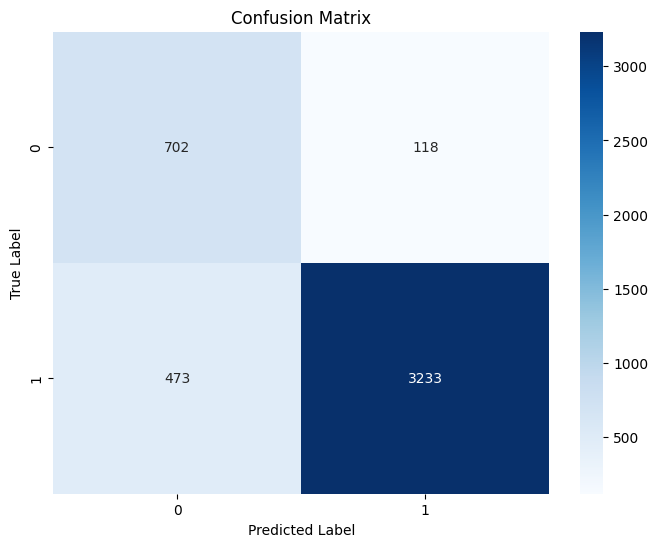

In [10]:
# Evaluate on test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Making Predictions

In [11]:
def predict_sentiment(review_text, model, tokenizer):
    """
    Predict sentiment for a given review text.
    Returns dictionary with original text, predicted sentiment, and confidence score.
    """
    # Clean the text
    cleaned_text = clean_text(review_text)

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH)

    # Get prediction probability
    prediction = model.predict(padded)[0][0]

    # Determine sentiment and confidence
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return {
        'text': review_text,
        'sentiment': sentiment,
        'confidence': f"{confidence * 100:.2f}%",
        'raw_score': prediction
    }

"""## 8. Test the Model with Sample Reviews"""
# Test with sample reviews
sample_reviews = [
    "The fit was perfect, soft and comfortable fabrics for sports",
    "bad quality fabric, made my skin irritated",
    "Decent product but a bit overpriced",
    "Love this dress! The color is beautiful and the material is high quality",
    "Sizing runs small, had to return it"
]

print("\nSample Predictions:")
for review in sample_reviews:
    result = predict_sentiment(review, model, tokenizer)
    print(f"\nReview: {result['text']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']}")
    print(f"Raw Score: {result['raw_score']:.4f}")



Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Review: The fit was perfect, soft and comfortable fabrics for sports
Sentiment: Positive
Confidence: 94.85%
Raw Score: 0.9485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Review: bad quality fabric, made my skin irritated
Sentiment: Negative
Confidence: 77.47%
Raw Score: 0.2253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Review: Decent product but a bit overpriced
Sentiment: Positive
Confidence: 59.59%
Raw Score: 0.5959
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Review: Love this dress! The color is beautiful and the material is high quality
Sentiment: Positive
Confidence: 62.52%
Raw Score: 0.6252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

Review: Sizing runs small, had to return it
Sentiment: Negative
Confidence: 84.50%
Raw Score: 0.1550


##Key improvements in this version include:

1.Enhanced text preprocessing with better cleaning.

2.Feature engineering with review length and word count.
3.Combined text from title and review.

4.Improved model architecture with bidirectional LSTM and dropout layers.

5.Class weights to handle imbalanced data.
6.Better callbacks for training (early stopping and learning rate reduction).

7.Comprehensive evaluation metrics including AUC score.

8.Detailed visualization of training history.

9.Enhanced prediction function with confidence scores